## **Этот ноутбук**: содержит код анализ данных, создания генератора, планирование стратегии тонкой настройки, а также: тест, обучение и вывод результата с сохранением топ-1 модели.

In [ ]:
# # # # 1. Монтируем Google Drive
# from google.colab import drive
# drive.mount('/content/drive')



# # 2. Копируем kaggle.json в нужную директорию
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

# # 3. Устанавливаем пра3ва на файл
# !chmod 600 ~/.kaggle/kaggle.json
# # 4. Устанавливаем kaggle API (если не установлен)
# # !pip install -q kaggle

# # 5. Пример скачивания датасета
# dataset_name = 'kehhill/queries'

# dataset_id = dataset_name.split('/')[-1]

# # # 5. Скачиваем датасет
# !kaggle datasets download -d {dataset_name}

# # # 6. Создаём папку и распаковываем тудк1а
# !mkdir -p {dataset_id}

# !unzip -q "{dataset_id}.zip" -d {dataset_id}

Грузим данные, создаём триплеты запрос-позитив-негатив. Текста делим на кластеры, в качестве негатива к каждому текста - какой-то текст из другого кластера.

In [ ]:
# path_to_model = "/content/drive/MyDrive/bge_fast_ten_lang_pretrained"
path_to_model = "/kaggle/input/queries/bge_fast_ten_lang_pretrained/bge_fast_ten_lang_pretrained"


# path_to_q = "/content/queries/fine_tune_10_langueges.parquet"
path_to_q =  "/kaggle/input/queries/fine_tune_10_langueges.parquet"

In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModel

# === Настройки ===



# === Загрузка токенизатора и ID из датасета ===
tokenizer = AutoTokenizer.from_pretrained(path_to_model)

# загружаем модель
model = AutoModel.from_pretrained(path_to_model)

2025-09-22 13:45:09.660893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758548710.011357      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758548710.116995      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import torch
from torch.nn.functional import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
from tqdm import tqdm



# --- читаем данные ---
all_q = pd.read_parquet(path_to_q)
texts = list(all_q.iloc[:, -1].unique())

In [ ]:
unique_ids = {text: idx for idx, text in enumerate(texts)}

# добавляем колонку с ID
all_q["desc_id"] = all_q.iloc[:, -1].map(unique_ids)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def _mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(last_hidden_state)  # [B,T,1]
    summed = (last_hidden_state * mask).sum(dim=1)                  # [B,D]
    denom = mask.sum(dim=1).clamp_min(1e-6)                         # [B,1]
    return summed / denom



In [ ]:

import torch
from tqdm import tqdm

batch_size = 128
embeddings = []
model.to('cuda')
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i : i + batch_size]

        inputs = tokenizer(
            list(batch_texts),
            return_tensors="pt",
            truncation=True,
            padding=True

        ).to("cuda")

        outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state  # [B, T, D]
        mask = inputs["attention_mask"]

        pooled = _mean_pool(last_hidden, mask)
        embeddings.append(pooled.cpu())

embeddings = torch.cat(embeddings, dim=0)  # [N, D]

100%|██████████| 46/46 [02:51<00:00,  3.73s/it]


In [ ]:
# --- косинусные сходства ---
# вариант с torch (экономия памяти, т.к. считаем блочно)
norm_emb = embeddings / embeddings.norm(dim=1, keepdim=True)
similarity_matrix = norm_emb @ norm_emb.T   # [N, N]

# переводим в numpy
similarity_matrix = similarity_matrix.numpy()
np.save("similarity_matrix.npy", similarity_matrix)

print(similarity_matrix.shape)
print(similarity_matrix[:5, :5])

(5851, 5851)
[[1.0000006  0.95481056 0.95418113 0.95452267 0.957865  ]
 [0.95481056 0.9999994  0.94676995 0.97657025 0.9436722 ]
 [0.95418113 0.94676995 0.9999993  0.9459999  0.9730275 ]
 [0.95452267 0.97657025 0.9459999  0.99999976 0.9320869 ]
 [0.957865   0.9436722  0.9730275  0.9320869  0.9999999 ]]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

X = embeddings.numpy()  # твои эмбеддинги [N, D]

In [ ]:




# scores = []
# range_n = range(2, 30, 3)  # перебираем число кластеров

# for k in range_n:
#     km = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = km.fit_predict(X)
#     score = silhouette_score(X, labels)
#     scores.append((k, score))

### спойлер: best_k = 5

In [ ]:
# # находим лучший k
# best_k, best_score = max(scores, key=lambda x: x[1])
# print("Оптимальное число кластеров:", best_k, "score:", best_score)

# # можно нарисовать график
# import matplotlib.pyplot as plt
# plt.plot([k for k,_ in scores], [s for _,s in scores], marker="o")
# plt.xlabel("число кластеров")
# plt.ylabel("silhouette score")
# plt.title("Подбор числа кластеров")
# plt.show()


In [ ]:
km = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = km.fit_predict(X)

In [ ]:
import numpy as np

# embeddings: np.array [N, D]
# clusters: np.array [N]
# labels: np.array [N] (например, idшники или индексы)

N, D = embeddings.shape
K = clusters.max() + 1

text_embeddings = []

rng = np.random.default_rng(42)  # фиксируем сид

for i in range(N):
    anchor = embeddings[i]
    c_anchor = clusters[i]

    # выбираем 3 случайных кластера, не равных своему
    other_clusters = [c for c in range(K) if c != c_anchor]
    chosen_clusters = rng.choice(other_clusters, size=3, replace=False)

    negatives = []
    for c in chosen_clusters:
        members = np.where(clusters == c)[0]
        neg_id = rng.choice(members)
        negatives.append(embeddings[neg_id])

    row = np.vstack([anchor, *negatives])  # [4, D]
    text_embeddings.append(row)

text_embeddings = np.stack(text_embeddings)  # [N, 4, D]
print(text_embeddings.shape)  # (N, 4, D)


(5851, 4, 1024)


Пайплайн обучение: генератор+лосс+оптимизаторы+утилиты

In [ ]:
k_for_test = 5000


cols = ['eng_Latn', 'ukr_Cyrl', 'deu_Latn', 'swe_Latn', 'por_Latn', 'ita_Latn',
       'fra_Latn', 'pol_Latn', 'ron_Latn', 'spa_Latn']

qs, desc_id = [], []

for i in range(len(all_q)):
  row = all_q.iloc[i]
  for col in cols: qs.append(row[col]); desc_id.append(row['desc_id'])

train_q = pd.DataFrame({'queries': qs[:-k_for_test],
                        'desc_id': desc_id[:-k_for_test]})

test_q = pd.DataFrame({'queries': qs[-k_for_test:],
                        'desc_id': desc_id[-k_for_test:]})

In [ ]:
import torch
from torch.utils.data import Dataset

class QueryTripletDataset(Dataset):
    def __init__(self, queries, text_embeddings):
        """
        queries         : список кортежей (query_text, text_id)
        text_embeddings : np.array [N, 4, D]
                          [0] = позитив, [1:4] = 3 негатива
        tokenizer       : HuggingFace AutoTokenizer
        """
        self.queries = queries
        self.text_embeddings = torch.tensor(text_embeddings)

    def __len__(self):
        return len(self.queries) * 3  # три строки на каждый запрос

    def __getitem__(self, idx):
        q_idx = idx // 3              # какой запрос
        n_idx = (idx % 3) + 1         # какой негатив (1, 2, 3)

        query_text = self.queries.loc[q_idx, "queries"]
        text_id = int(self.queries.loc[q_idx, "desc_id"])

        positive = self.text_embeddings[text_id, 0]      # [D]
        negative = self.text_embeddings[text_id, n_idx]  # [D]

        return {
            "queries": query_text,
            "positive": positive,
            "negative": negative,
        }





In [ ]:
from torch.utils.data import DataLoader
from transformers import AutoTokenizer


test_d = QueryTripletDataset(test_q, text_embeddings)
train_d = QueryTripletDataset(train_q, text_embeddings)
train_loader = DataLoader(train_d, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_d, batch_size=48, shuffle=False, pin_memory=True)

In [ ]:
def build_layer_param_map(model):
    """
    Делает словарь {layer_idx: [имена параметров]} для encoder.layer.*,
    плюс "others" для всего остального.
    """
    layer_map = {}
    total = len(model.encoder.layer)

    for n, p in model.named_parameters():
        matched = False
        for i in range(total):
            if f"encoder.layer.{i}." in n:
                idx = i + 1  # 1-based индекс
                layer_map.setdefault(idx, []).append(n)
                matched = True
                break
        if not matched:
            layer_map.setdefault("others", []).append(n)

    return layer_map

layer_map = build_layer_param_map(model)

In [ ]:
def set_layer_lrs(model, assignments, base_opt=torch.optim.AdamW, layer_map=None, **opt_kwargs):
    """
    Если optimizer=None -> создаём новый AdamW с группами под assignments.
    Если optimizer передан -> пересоздаём его param_groups (без потери state).
    """
    assert layer_map is not None, "Нужен layer_map!"

    # проверяем корректность assignments
    all_parts = list(layer_map.keys())
    model_part_assign = [j for i in assignments for j in i[0]]
    missed_layers = [i for i in all_parts if i not in model_part_assign]
    bad_layers = [i for i in model_part_assign if i not in all_parts]
    assert missed_layers==[], f"Assignment should contain all layers that model has! You missed: {missed_layers}"
    assert bad_layers==[], f"You point layers that model hasn't: {bad_layers}"

    # строим группы
    param_groups = []
    for indices, val in assignments:
        for idx in indices:
            names = layer_map[idx]
            params = [p for n, p in model.named_parameters() if n in names]
            group = {"params": params, "name": f"layer_{idx}"}
            if val == "freeze":
                for p in params:
                    p.requires_grad = False
                group["lr"] = 0.0
                group["frozen"] = True
            else:
                for p in params:
                    p.requires_grad = True
                group["lr"] = float(val)
                group["frozen"] = False
            param_groups.append(group)


    optimizer = base_opt(param_groups, **opt_kwargs)

    return optimizer


In [ ]:
def scale_unfrozen_lrs(optimizer, factor):
    """
    action = 'increase' или 'decrease'
    factor = число, например 2.0
    """
    for g in optimizer.param_groups:
        if not g.get("frozen", False):
            g["lr"] *= factor


In [ ]:
def wurm_up_sheduler(optimizer, cur_step, wurm_up_steps=1000):
  if cur_step<=wurm_up_steps:
      scale_unfrozen_lrs(optimizer, cur_step/wurm_up_steps)

In [ ]:
import math
import time
import torch
import torch.nn.functional as F

In [ ]:
def triplet_loss_hard(q, p, n, margin=0.3):
    pos_dist = 1.0 - F.cosine_similarity(q, p)  # меньше — лучше
    neg_dist = 1.0 - F.cosine_similarity(q, n)  # больше — лучше
    return F.relu(margin + pos_dist - neg_dist).mean()

# def make_triplet_loss_fn(margin=0.3):
#     return lambda q,p,n: triplet_loss_hard(q,p,n,margin)

# loss_fn = make_triplet_loss_fn() # вставить триплет лосс

In [ ]:
import torch
from torch.cuda.amp import autocast, GradScaler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_

# --- готовим модель, оптимайзер ---
device = "cuda"
model.to(device)

# оптимайзер
from torch.optim import AdamW

assign = [(['others', 1,2,3], 'freeze'),([4,5,6], 2e-5),([7,8,9], 5e-5)]

optimizer = set_layer_lrs(model, assign, base_opt=torch.optim.AdamW, layer_map=layer_map)

# grad scaler для FP16
scaler = GradScaler(enabled=True)

val_freq = 1000 # in steps
# --- тренинг ---
num_epochs = 3
stop_training = False
base_patience = 2
patience = base_patience  # works only after phase 2

val_loss_dynamic = [1000]


report = pd.DataFrame({'step': [-1], 'val_loss': [1000]})


wurm_up_steps = 1000
step = 0


for epoch in range(num_epochs):

    running_loss = 0.0

    if stop_training: break
    for batch in train_loader:
        if stop_training: break
        step+=1

        query_text = batch["queries"]
        positive = batch["positive"].to(device)
        negative = batch["negative"].to(device)

        encoded = tokenizer(
            query_text,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )


        ids = encoded["input_ids"].to(device)
        attn = encoded["attention_mask"].to(device)

        model.zero_grad(set_to_none=True)


        with autocast(enabled=True):
            output = model(ids, attn).last_hidden_state.mean(dim=1)
            # забираем student эмбеддинги
            loss = triplet_loss_hard(output, positive, negative)


        scaler.scale(loss).backward()

        # grad clipping (после unscale)
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        # шаг оптимизатора
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()



        wurm_up_sheduler(optimizer, step, wurm_up_steps=wurm_up_steps)

        if step % 1000 == 0:
            print(f"epoch {epoch} step {step} | loss {running_loss/400:.4f}")

            if epoch==0: # если модель видит данные впервые то тренировочная выборка годится и как валидационная

                val_loss = running_loss/1000
                report.loc[len(report)] = [step, val_loss]
                report.to_csv("report.csv")
                print(f"epoch {epoch} | step {step} | val_loss={val_loss:.4f}")

                if min(report['val_loss'][:-1])*0.98<=val_loss:
                    patience-=1
                    scale_unfrozen_lrs(optimizer, 1/2)
                    if patience==0:
                      print("Traing stopped on epoch {epoch+1}, step {step} due to no progress!")
                      stop_training = True

                if min(report['val_loss'][:-1])*0.98>val_loss:
                  print('Save new best model with val loss ', val_loss)
                  patience = base_patience
                  save_small = 'bge_for_films_searching'
                  os.makedirs(save_small, exist_ok=True)
                  model.save_pretrained(save_small)

            running_loss = 0.0

        if step>wurm_up_steps and step%val_freq==0 and epoch!=0:
          model.eval()
          val_loss = 0.0
          with torch.inference_mode():
              for batch in test_loader:
                  query_text = batch["queries"]
                  positive = batch["positive"].to(device)
                  negative = batch["negative"].to(device)

                  encoded = tokenizer(
                      query_text,
                      truncation=True,
                      padding=True,
                      return_tensors="pt"
                  )

                  ids = encoded["input_ids"].to(device)
                  attn = encoded["attention_mask"].to(device)

                  model.zero_grad(set_to_none=True)


                  with autocast(enabled=True):
                      output = model(ids, attn).last_hidden_state.mean(dim=1)
                      # забираем student эмбеддинги
                      loss = triplet_loss_hard(output, positive, negative)


                  val_loss += loss.item()

          val_loss /= len(test_loader)

          report.loc[len(report)] = [step, val_loss]
          report.to_csv("report.csv")


          print(f"epoch {epoch} | step {step} | val_loss={val_loss:.4f}")

          if min(report['val_loss'][:-1])*0.98<=val_loss:
              patience-=1
              scale_unfrozen_lrs(optimizer, 1/2)
              if patience==0:
                print("Traing stopped on epoch {epoch+1}, step {step} due to no progress!")
                stop_training = True
                break
          if min(report['val_loss'][:-1])*0.98>val_loss:
            print('Save new best model with val loss ', val_loss)
            patience = base_patience
            save_small = 'bge_for_films_searching'
            os.makedirs(save_small, exist_ok=True)
            model.save_pretrained(save_small)
          model.train()

/tmp/ipykernel_19/2441760645.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
/tmp/ipykernel_19/2441760645.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 0 step 1000 | loss 0.6257
epoch 0 | step 1000 | val_loss=0.2503
Save new best model with val loss  0.2502965271472931


/tmp/ipykernel_19/2441760645.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 0 step 2000 | loss 0.6249
epoch 0 | step 2000 | val_loss=0.2500


/tmp/ipykernel_19/2441760645.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 0 step 3000 | loss 0.6255
epoch 0 | step 3000 | val_loss=0.2502
Traing stopped on epoch {epoch+1}, step {step} due to no progress!


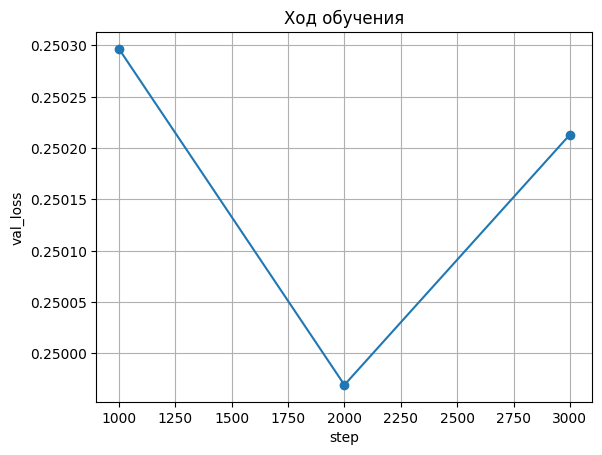

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# допустим твой датасет в df
report = report.iloc[1:]
plt.plot(report.iloc[:, 0], report.iloc[:, 1], marker='o', linestyle='-')
plt.xlabel(report.columns[0])
plt.ylabel(report.columns[1])
plt.title("Ход обучения")
plt.grid(True)
plt.show()

### Модель смогла добиться расхождение между позитивными результатами и негативными в 0.05 косинуса - это отличный результат. Более того: наши описания достаточно "сырые": много пропусков, мало аспектов, нет те же: год, оценка и так далее. Итог: модель можно смело использовать для продакта.